# Ultimate Technologies, Inc.
## Take-Home Challenge 

#### Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read json file and view resulting df
logins = pd.read_json('logins.json')
logins = logins.sort_values('login_time').reset_index(drop=True)
logins

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37
...,...
93137,1970-04-13 18:48:52
93138,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93140,1970-04-13 18:54:23


In [3]:
# Inspect dtypes and length
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


The data looks to be complete. One thing to note - the data are for the year 1970, which surely must be a mistake! We should make sure to tell the data manager to correct the year.

In the first step, we'll aggregate in 15-min increments giving a count of logins. For ease, we'll also extract the day of week and the time for each increment.

In [4]:
# Add column of 1s
logins['login_count'] = 1

In [5]:
# Group by 15-min bin, agg with count
counts = logins.groupby(pd.Grouper(key='login_time', freq='15min', origin='1970-01-01 20:00:00')).count().reset_index()

# Add columns for day name and time for each bin
counts['day'] = counts.apply(lambda row: row.login_time.day_name(), axis=1)
counts['bin'] = counts.apply(lambda row: str(row.login_time.time()), axis=1)
counts

,login_time,login_count,day,bin
0,1970-01-01 20:00:00,2,Thursday,20:00:00
1,1970-01-01 20:15:00,6,Thursday,20:15:00
2,1970-01-01 20:30:00,9,Thursday,20:30:00
3,1970-01-01 20:45:00,7,Thursday,20:45:00
4,1970-01-01 21:00:00,1,Thursday,21:00:00
...,...,...,...,...
9783,1970-04-13 17:45:00,5,Monday,17:45:00
9784,1970-04-13 18:00:00,5,Monday,18:00:00
9785,1970-04-13 18:15:00,2,Monday,18:15:00
9786,1970-04-13 18:30:00,7,Monday,18:30:00


First, let's take a look at the whole dataset, and see if there's an overall trend

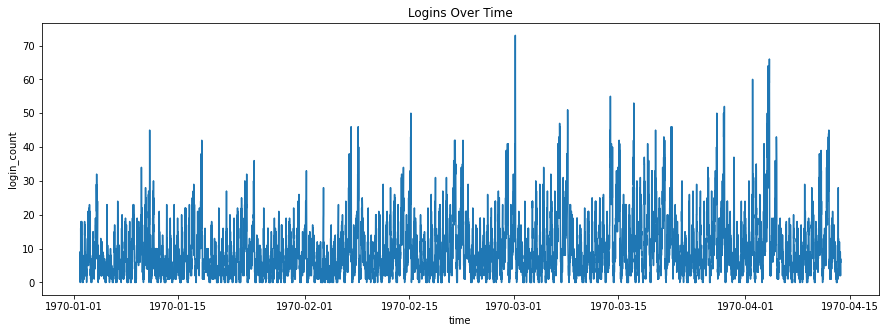

In [6]:
# Line graph of logins over full time of dataset
plt.figure(figsize=(15, 5))
sns.lineplot(data=counts,
            x='login_time',
            y='login_count')
plt.title('Logins Over Time')
plt.xlabel('time');

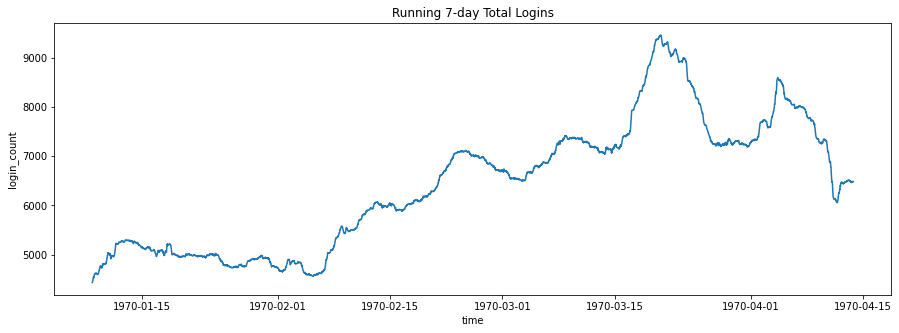

In [7]:
# Let's compute a weekly rolling sum to see a larger trend. The window will be 4 increments/hour * 24 hours/day * 7 days
weekly_sum = counts.login_count.rolling(window=(4*24*7)).sum()

# Plot the rolling total over the full period of the dataset
plt.figure(figsize=(15, 5))
sns.lineplot(data=counts,
            x='login_time',
            y=weekly_sum)
plt.title('Running 7-day Total Logins')
plt.xlabel('time');

On the first graph, we should note the best 15-minute bin was near March 1. There are also apparent daily and weekly patterns adding noise to the line graph. 

On the weekly rolling total graph, we can see that the number of weekly logins was increasing, with a peak around March 22. The latest data, however, shows that the growth has dropped off and may be decreasing overall.

Next, we'll take a look at the average counts by day to more closely examine the daily patterns.

In [8]:
# First, let's put the data in order by bin to make sure our graphs start at midnight
counts2 = counts.sort_values('bin')
counts2

,login_time,login_count,day,bin
7888,1970-03-25 00:00:00,9,Wednesday,00:00:00
1168,1970-01-14 00:00:00,9,Wednesday,00:00:00
9520,1970-04-11 00:00:00,31,Saturday,00:00:00
2032,1970-01-23 00:00:00,11,Friday,00:00:00
6736,1970-03-13 00:00:00,26,Friday,00:00:00
...,...,...,...,...
3087,1970-02-02 23:45:00,8,Monday,23:45:00
2127,1970-01-23 23:45:00,18,Friday,23:45:00
5775,1970-03-02 23:45:00,4,Monday,23:45:00
399,1970-01-05 23:45:00,5,Monday,23:45:00


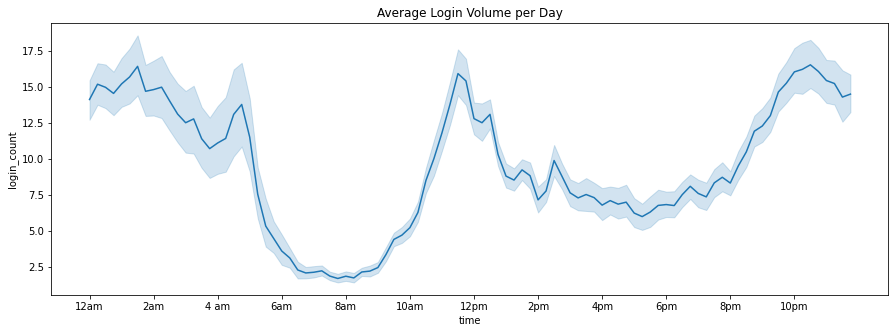

In [9]:
# Plot login counts in each bin, averaging all days together
plt.figure(figsize=(15, 5))
sns.lineplot(data=counts2,
             x='bin',
             y='login_count')

# Make easy-to-read ticks every 2 hours
ticks = range(0, 96, 8)
tick_labels = ['12am', '2am', '4 am', '6am', '8am', '10am', '12pm', '2pm', '4pm', '6pm', '8pm', '10pm']
plt.xticks(ticks=ticks, labels=tick_labels)
plt.title('Average Login Volume per Day')
plt.xlabel('time');

Averaging all days, we see that the least busy time is from about 5am to 10am, with a smaller lull around 5pm. However, we know there is also a weekly cycle to account for. Let's make this graph for each day of the week to compare.

In [10]:
# Make a list of days for easy ordering
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

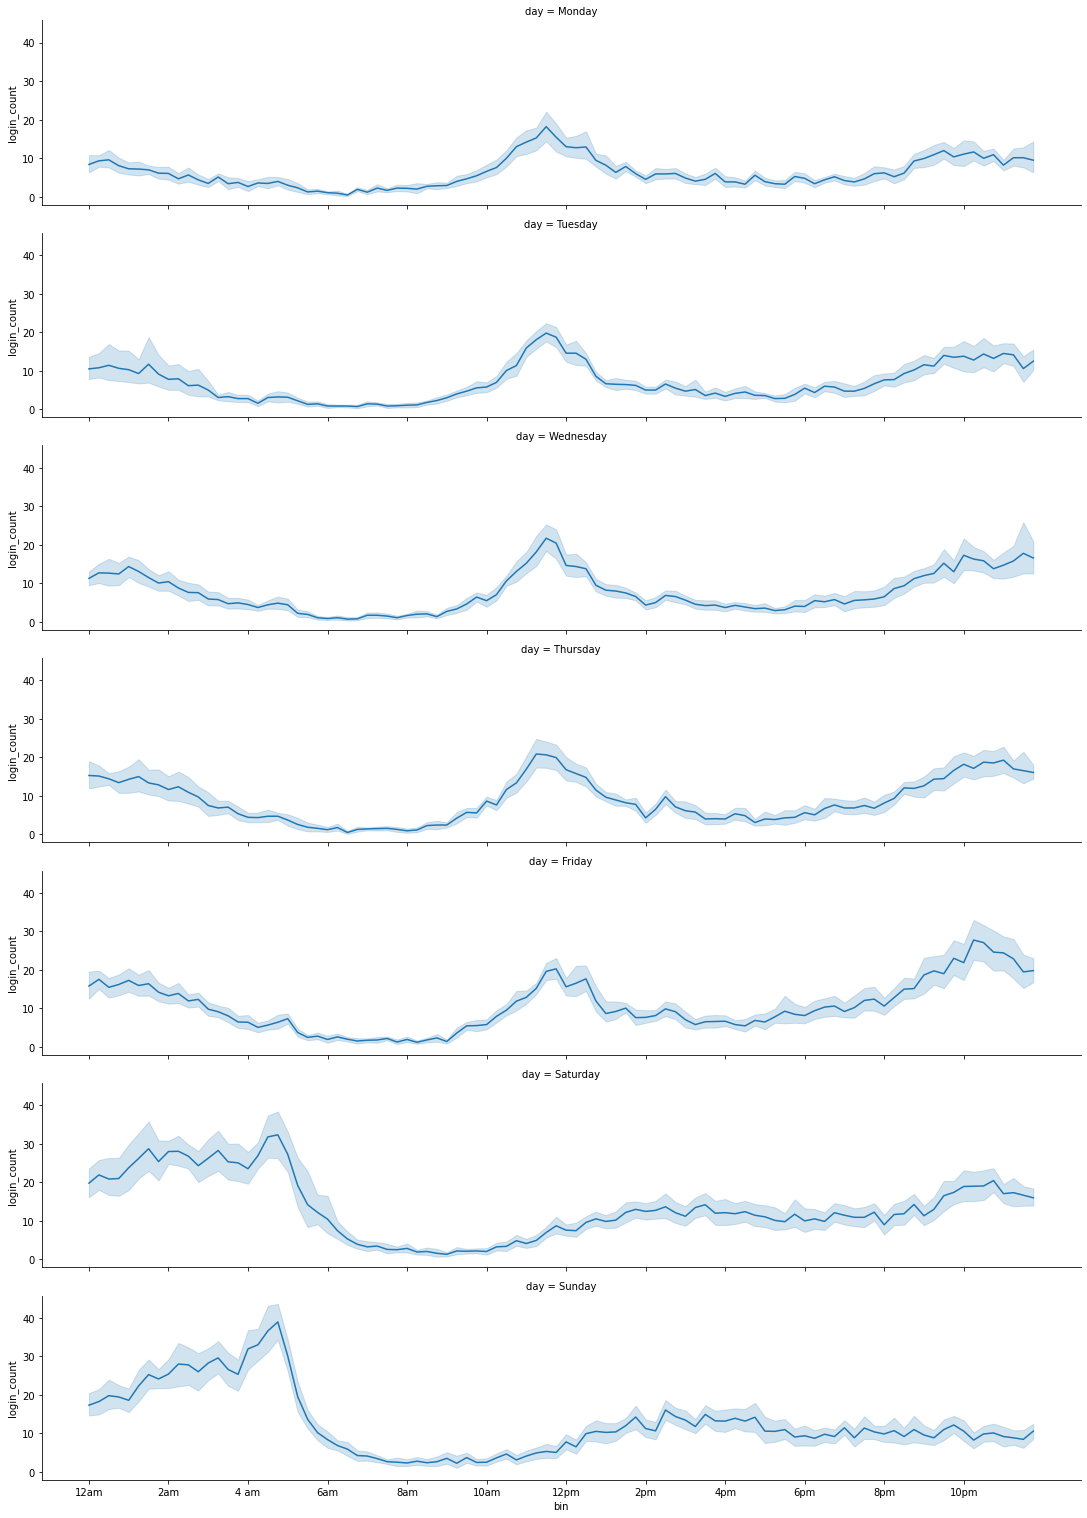

In [11]:
# Plot average # logins for each bin, separately for each day of the week
sns.relplot(kind='line',
           data=counts2,
           x='bin',
           y='login_count',
           row='day',
           row_order=day_order,
           height=3,
           aspect=5)
plt.xticks(ticks=ticks, labels=tick_labels);

Here we see that the day of the week makes a huge difference. Weekdays have small peaks at noon and midnight, while Weekends have a large upsurge in logins from midnight to about 5am, then a steep drop that stays low the rest of the day.

Finally, let's visualize the weekly trends in another way by aggregating logins by day rather than 15-minute increments.

In [12]:
# Group login df by date, keeping daily count and day of week name
weekly = logins.groupby(
            pd.Grouper(key='login_time', freq='D', origin='1970-01-01 00:00:00'))\
            .count().reset_index()
weekly['day'] = weekly.apply(lambda row: row.login_time.day_name(), axis=1)
weekly

,login_time,login_count,day
0,1970-01-01,112,Thursday
1,1970-01-02,681,Friday
2,1970-01-03,793,Saturday
3,1970-01-04,788,Sunday
4,1970-01-05,459,Monday
...,...,...,...
98,1970-04-09,818,Thursday
99,1970-04-10,1009,Friday
100,1970-04-11,1352,Saturday
101,1970-04-12,1409,Sunday


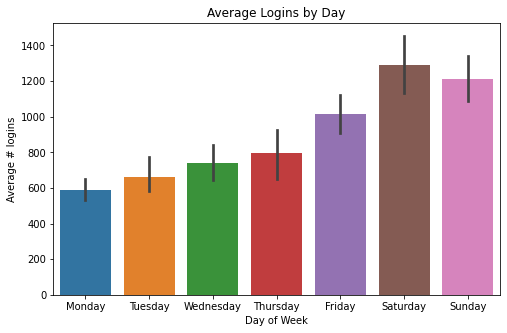

In [13]:
# Graph average # of logins by day of week
plt.figure(figsize=(8, 5))
sns.barplot(data=weekly, x='day', y='login_count', 
            order=day_order)

plt.title('Average Logins by Day')
plt.xlabel('Day of Week')
plt.ylabel('Average # logins');

Logins increase steadily over the week, with Saturday having over twice the number of logins as Monday, on average.

#### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

***
A good key measure of success for this experiment would be total number of inter-city trips. Assuming that we already know the trips are profitable (the higher revenue from these trips exceeds the added cost of reimbursing tolls), we would define success by seeing a significant increase in the number of these trips.

For the experiment, I would start by giving all drivers the option to be reimbursed for tolls for a trial period of 2-4 weeks. Giving the option to only some drivers might cause confusion and dissatisfaction from both drivers and customers, and we want to give them enough time to hear about and become comfortable with the idea of being reimbursed. Once the full trial period is over, we can look at the data.

To ensure that the change is statistically significant, we can compare the number of inter-city trips during the trial with the same data from the previous year, accounting for year-on-year growth. We'd perform a chi-squared test comparing the expected and actual frequency of rides, under the null hypothesis here is that there was no change in the number of inter-city trips during the experiment. If the observed frequency is high enough to be very unlikely to have occured by chance assuming the null hypthesis is true (p < 0.05), then we can say the experiment was successful - offering toll reimbursement led to more inter-city rides.

In that case, I would recommend that the city operations team makes the toll reimbursement permanent. However, both frequency of inter-city rides and overall profitability should constantly be monitored to make sure that the higher revenue from these rides makes the higher costs worthwhile.
***

#### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

**Data description**
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday


In [14]:
df = pd.read_json('ultimate_data_challenge.json')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [17]:
# We can easily take care of null values in phone by filling with the most common value
df.phone.value_counts(dropna=False)

iPhone     34582
Android    15022
NaN          396
Name: phone, dtype: int64

In [18]:
df.phone.fillna('iPhone', inplace=True)

<AxesSubplot:>

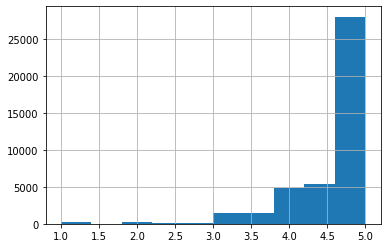

In [19]:
# avg_rating_of_driver is nearing 20% null. Let's check the distribution and see if it makes sense to fill na's or drop them
df.avg_rating_of_driver.hist()

In [20]:
df.avg_rating_of_driver.describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [21]:
# The distribution is heavily skewed - over half of the data has a value of 4.9 or 5.0. We'll fill with the median.
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.median(), inplace=True)

In [22]:
df.avg_rating_by_driver.describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [23]:
# Same for the rating by driver, though there are much fewer null rows.
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.median(), inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [25]:
# Next we need a column for our dependent var: whether a user is active in the sixth month
# We'll define 'active' as within the 30 days before the last day of the dataset, which is 2014-07-01
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)
today = pd.to_datetime('2014-07-01')

# Create a Boolean column of whether the user is active
df['active'] = df.apply(lambda row: True if (today - row.last_trip_date).days <= 30 else False, axis=1)

# Calculate percentage of users still active from this cohort
print("Users who are still active: ", df.active.sum())
print("Percentage of total users: ", round(df.active.sum()/len(df)*100, 2), "%")

Users who are still active:  18804
Percentage of total users:  37.61 %


Almost 40% of the customers are still active within the last month. Let's quickly examine each feature

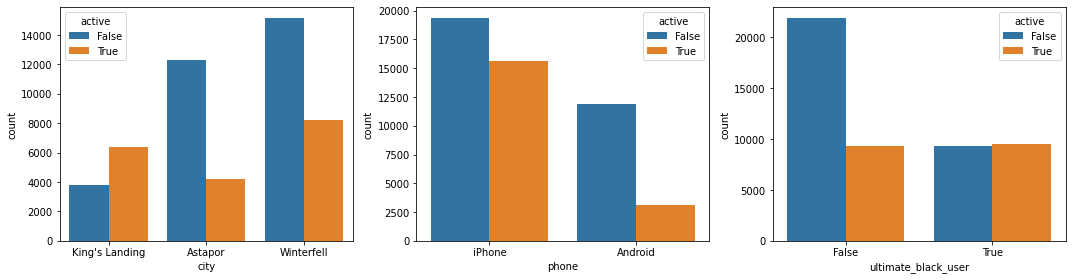

In [26]:
# Make countplots to compare values in the categorical columns
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.countplot(data=df, 
             x='city',
             hue='active')

plt.subplot(1, 3, 2)
sns.countplot(data=df, 
             x='phone',
             hue='active')

plt.subplot(1, 3, 3)
sns.countplot(data=df, 
             x='ultimate_black_user',
             hue='active')

plt.tight_layout();

All of these categorical columns seem to be related to retention. Users from King's Landing, Ultimate Black users, and iPhone users are all more likely to be active after 6 months.

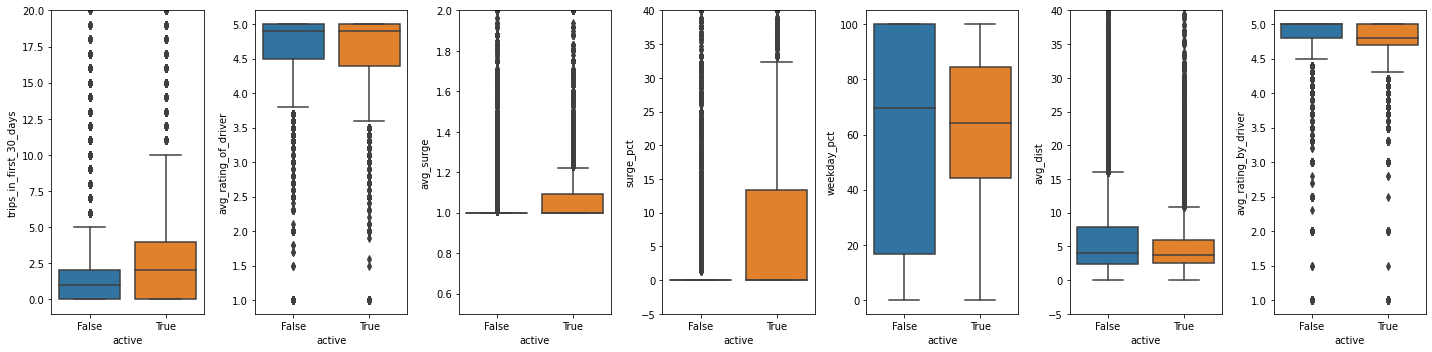

In [27]:
# Create boxplots for quantitative features. We'll zoom in on the IQRs for each graph rather than getting rid of outliers
plt.figure(figsize = (20, 5))

plt.subplot(1, 7, 1)
plt.ylim((-1, 20))
sns.boxplot(data=df,
           y='trips_in_first_30_days',
           x='active')

plt.subplot(1, 7, 2)
sns.boxplot(data=df,
           y='avg_rating_of_driver',
           x='active')

plt.subplot(1, 7, 3)
plt.ylim((0.5, 2))
sns.boxplot(data=df,
           y='avg_surge',
           x='active')

plt.subplot(1, 7, 4)
plt.ylim((-5, 40))
sns.boxplot(data=df,
           y='surge_pct',
           x='active')

plt.subplot(1, 7, 5)
sns.boxplot(data=df,
           y='weekday_pct',
           x='active')

plt.subplot(1, 7, 6)
plt.ylim((-5, 40))
sns.boxplot(data=df,
           y='avg_dist',
           x='active')

plt.subplot(1, 7, 7)
sns.boxplot(data=df,
           y='avg_rating_by_driver',
           x='active')

plt.tight_layout();

One takeaway from these graphs is the difference between our target groups in surge pricing: the still active users are more likely to have taken trips with surge pricing. We can also see that the lapsed customers have a wider range of weekday rates and greater percentage of customers who take weekday rides exclusively, whereas the active customers mainly fall between 40-80% for weekday_pct.

Next, we can build our model. Because many of our features have a lot of outliers (and the outliers are reliable data, just extreme examples of customer behavior), it may be best to choose a decision tree model that is more robust to outliers. I think a Random Forest model will be a good choice, as it is robust to outliers and also shouldn't require the data to be normalized or rescaled.

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_roc_curve, plot_precision_recall_curve

In [54]:
df_features = pd.get_dummies(df)
df_features

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,True,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,False,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,False,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,True,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.0,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,True,0,1,0,0,1
49996,1,2014-01-24,4.9,1.00,2014-01-25,0.0,False,0.0,0.00,4.0,False,1,0,0,0,1
49997,0,2014-01-31,5.0,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,False,0,0,1,1,0
49998,2,2014-01-14,3.0,1.00,2014-01-15,0.0,False,100.0,4.58,3.5,False,1,0,0,0,1


In [68]:
# Separate feature vector and dependent variable, as well as delete redundant iPhone column
X = df_features.drop(columns=['signup_date', 'last_trip_date', 'active', 'phone_iPhone'])
y = df_features.active

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [69]:
# Check to make sure there's not a large imbalance in proportion of target variable in train and test sets
print(y_train.mean(), y_test.mean())

0.375775 0.3773


In [57]:
rfc = RandomForestClassifier()

We want our model to have good accuracy, so I will optimize hyperparameters using the balanced accuracy (to account for the 40-60 imbalance of the positive case). It may be good, however, to check with decision-making staff to see what will be done with the predictions from the model. If it's more important to identify every customer who will stay active (even if we misidentify some customers who would not), perhaps recall is more important than accuracy, for example.

In [37]:
# Choose ranges of hyperparameters for Randomized Search Cross Validation, and print best score and associated params.
param_grid2 = {
    'n_estimators':range(50, 201, 25),
    'max_depth':range(4,15),
    'max_features':range(2,12)
}
param_cv2 = RandomizedSearchCV(rfc, param_grid2, scoring='balanced_accuracy', random_state=36, n_jobs=-1)
param_cv2.fit(X_train, y_train)

print(param_cv2.best_score_)
param_cv2.best_params_

0.7587727828744953


{'n_estimators': 150, 'max_features': 5, 'max_depth': 10}

In [70]:
# Instantiate and fit model with the best parameters
rfc = RandomForestClassifier(n_estimators=150, max_features=5, max_depth=10)
model = rfc.fit(X_train, y_train)
preds = model.predict(X_test)

# Print accuracy metrics
print(classification_report(preds, y_test))
print('Accuracy on test set:',model.score(X_test, y_test))

              precision    recall  f1-score   support

       False       0.86      0.81      0.83      6652
        True       0.66      0.74      0.70      3348

    accuracy                           0.78     10000
   macro avg       0.76      0.77      0.77     10000
weighted avg       0.79      0.78      0.79     10000

Accuracy on test set: 0.7847


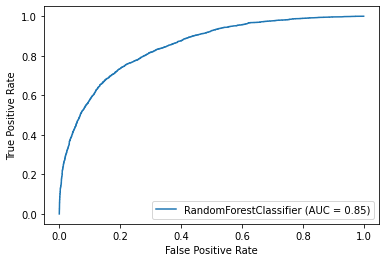

In [71]:
plot_roc_curve(model, X_test, y_test)

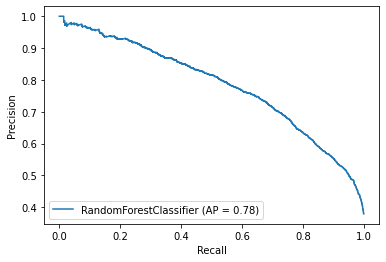

In [72]:
plot_precision_recall_curve(model, X_test, y_test)

***
I first filled in missing data with median column values for both rating columns, and the most common value of phone, "iPhone". Using the last_trip_date column, I created the desired target variable, "active," which is True for any customer who has taken a trip in the previous 30 days, and False otherwise. About 38% of the customers in this cohort are still active. Looking across columns, it's clear that a customer's city, phone type, whether they use Ultimate Black, and their use of surge pricing are all somehow correlated with being active in the sixth month.

I chose to train a Random Forest model, which I hoped would do a good job handling the numerical columns, many of which have skewed distributions (both ratings of driver and ratings by driver, for example, tend to be close to 5 for most users). I tuned the hyperparameters (number of trees, max depth per tree, and number of features to sample for each estimator) using balanced accuracy, to achieve accurate predictions that account for the slight imbalance of the target variable. I think optimizing accuracy in this case is a better goal than using recall or precision, as we want both high true positives and true negatives. THe resulting model had 150 estimators with max depth 10, and max features 5 (out of 12). The accuracy on the test set was 78%, with the area under the ROC curve was 0.85.

I think this model could be helpful to get an idea of users who will churn, but I would suggest trying some other models first to see if performance could be improved. A boosted tree model, for example, might be able to learn from this data better, improving on the 78% accuracy.

With these predictions, Ultimate Technologies can develop strategies of customer retention that focuses on customers who are more likely to churn. One possible strategy could be to offer discounted rates to these customers. Since surge pricing seems to be a big differentiating factor, perhaps they should limit the times or rate of surge pricing for customers predicted to churn. Another strategy might be to remind users to keep using the service regularly, especially in the first 30 days.

Another way to improve would be to try to determine why certain customers stop using the service. Perhaps Android users churn more because the Android app does not work as well as the iPhone app. Ultimate should also look into why riders stay active in King's Landing more than other cities - are the drivers better/more available? It may be necessary to recruit more drivers in other cities.
***